# numpy实现MLP分类

## 安装依赖 设置隐藏层数量

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

layers_dims = [50, 10]

## 自定义MLP类

In [ ]:
class MLP:
    def __init__(self, layer_size, activation="sigmoid"):
        self.layer_size = layer_size
        self.parameters = {}
        self.layer_num = len(self.layer_size)
        self.losses = []
        self.activation = activation

    # 初始化参数
    def initialize_parameters(self):
        np.random.seed(1)
        for l in range(1, len(self.layer_size)):
            self.parameters["w" + str(l)] = np.random.randn(self.layer_size[l], self.layer_size[l - 1]) / np.sqrt(
                self.layer_size[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layer_size[l], 1))

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def relu_derivative(self, x):
        return 1 if x > 0 else 0

    def sigmoid_derivative(self, x):
        s = 1 / (1 + np.exp(-x))
        return s * (1 - s)

    def tanh_derivative(self, x):
        return 1 - np.power(self.tanh(x), 2)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=0, keepdims=True)

    # 前向传播
    def forward(self, X):
        output = {}
        a = X.T
        for l in range(self.layer_num - 1):
            z = self.parameters["w" + str(l + 1)].dot(a) + self.parameters["b" + str(l + 1)]
            # 选择激活函数
            if self.activation == "sigmoid":
                a = self.sigmoid(z)
            elif self.activation == "relu":
                a = self.relu(z)
            elif self.activation == "tanh":
                a = self.tanh(z)
            output["a" + str(l + 1)] = a
            output["w" + str(l + 1)] = self.parameters["w" + str(l + 1)]
            output["z" + str(l + 1)] = z
        # 更新参数
        z = self.parameters["w" + str(self.layer_num)].dot(a) + self.parameters["b" + str(self.layer_num)]
        a = self.softmax(z)
        output["a" + str(self.layer_num)] = a
        output["w" + str(self.layer_num)] = self.parameters["w" + str(self.layer_num)]
        output["z" + str(self.layer_num)] = z
        return a, output

    # 反向传播
    def backward(self, X, y, store):
        # 样本数量
        m = X.shape[0]
        derivatives = {}
        store["a0"] = X.T

        A = store["a" + str(self.layer_num)]
        dZ = A - y.T

        dW = dZ.dot(store["a" + str(self.layer_num - 1)].T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dAPrev = store["w" + str(self.layer_num)].T.dot(dZ)

        derivatives["dw" + str(self.layer_num)] = dW
        derivatives["db" + str(self.layer_num)] = db

        for l in range(self.layer_num - 1, 0, -1):
            if self.activation == "sigmoid":
                dZ = dAPrev * self.sigmoid_derivative(store["z" + str(l)])
            elif self.activation == "relu":
                dZ = dAPrev * self.relu_derivative(store["z" + str(l)])
            elif self.activation == "tanh":
                dZ = dAPrev * self.tanh_derivative(store["z" + str(l)])
            dW = 1. / m * dZ.dot(store["a" + str(l - 1)].T)
            db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = store["w" + str(l)].T.dot(dZ)

            derivatives["dw" + str(l)] = dW
            derivatives["db" + str(l)] = db

        return derivatives

    # 训练
    def train(self, X, y, epochs=10, learning_rate=0.001, optimizer='sgd', l1_reg_coef=0.0, l2_reg_coef=0.0):
        num_examples = X.shape[0]
        np.random.seed(1)
        self.layer_size.insert(0, X.shape[1])
        self.initialize_parameters()

        # 根据优化器类型创建优化器实例
        if optimizer == 'sgd':
            optimizer = SGD(learning_rate)
        elif optimizer == 'adam':
            optimizer = Adam(learning_rate)
        else:
            raise ValueError("Unsupported optimizer. Please use 'sgd' or 'adam'.")

        for epoch in range(epochs):
            A, output = self.forward(X)
            loss = -np.mean(y * np.log(A.T + 1e-8))
            derivatives = self.backward(X, y, output)

            for l in range(1, self.layer_num + 1):
                # L1正则化
                l1_reg_term = l1_reg_coef * np.abs(self.parameters["w" + str(l)])
                # L2正则化
                l2_reg_term = 0.5 * l2_reg_coef * np.square(self.parameters["w" + str(l)])
                self.parameters["w" + str(l)] = self.parameters["w" + str(l)] - learning_rate * (derivatives[
                    "dw" + str(l)] + l1_reg_term + l2_reg_term)
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives[
                    "db" + str(l)]

                # 使用优化器更新参数
                updated_parameters = optimizer.update(self.parameters, derivatives)
                self.parameters = updated_parameters

            # 打印损失和准确率
            if epoch % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {self.predict(X, y):.4f}")

            if epoch % 10 == 0:
                self.losses.append(loss)
 
    # 预测
    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100

    # 绘制损失函数曲线
    def loss_plot(self):
        plt.figure()
        plt.plot(np.arange(len(self.losses)), self.losses)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.show()

## 自定义SGD、Adam优化器

In [ ]:
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameters, gradients):
        updated_parameters = {}
        for key, value in parameters.items():
            updated_parameters[key] = value - self.learning_rate * gradients[f"d{key}"]
        return updated_parameters

class Adam:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, parameters, gradients):
        self.t += 1
        updated_parameters = {}

        for key, value in parameters.items():
            # 初始化一阶矩估计和二阶矩估计
            if key not in self.m:
                self.m[key] = np.zeros_like(value)
                self.v[key] = np.zeros_like(value)

                # 计算一阶矩估计
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * gradients[f"d{key}"]
            # 计算二阶矩估计
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * np.square(gradients[f"d{key}"])

            # 对一阶矩估计进行偏差修正
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            # 对二阶矩估计进行偏差修正
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)

            # 更新参数
            updated_parameters[key] = value - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return updated_parameters

## 加载数据集开始训练
### 设置隐藏层参数、激活函数、训练轮次、学习率、优化器、L1和L2正则化系数

In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten images and normalize
X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

# Convert labels to one-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

# Initialize and train the model
model = MLP(layers_dims, activation="sigmoid")
model.train(X_train, y_train_one_hot, epochs=1000, learning_rate=0.1, optimizer='sgd', l1_reg_coef=0.01, l2_reg_coef=0.001)

## 预测并分析结果

Epoch 1/1000, Loss: 0.2401, Accuracy: 9.0683
Epoch 101/1000, Loss: 0.0833, Accuracy: 83.3417
Epoch 201/1000, Loss: 0.0531, Accuracy: 87.5150
Epoch 301/1000, Loss: 0.0428, Accuracy: 89.0333
Epoch 401/1000, Loss: 0.0375, Accuracy: 89.8483
Epoch 501/1000, Loss: 0.0341, Accuracy: 90.5233
Epoch 601/1000, Loss: 0.0317, Accuracy: 91.0533
Epoch 701/1000, Loss: 0.0297, Accuracy: 91.4917
Epoch 801/1000, Loss: 0.0281, Accuracy: 91.9167
Epoch 901/1000, Loss: 0.0266, Accuracy: 92.2783
Mean Squared Error: 1.29
Variance Score: 0.85


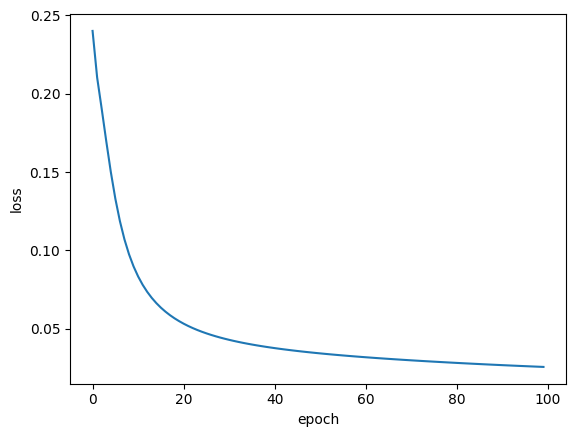

Classification report for our MLP:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.94      0.92      0.93      1032
           3       0.92      0.93      0.92      1010
           4       0.92      0.93      0.93       982
           5       0.92      0.88      0.90       892
           6       0.94      0.96      0.95       958
           7       0.94      0.93      0.93      1028
           8       0.90      0.91      0.91       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000




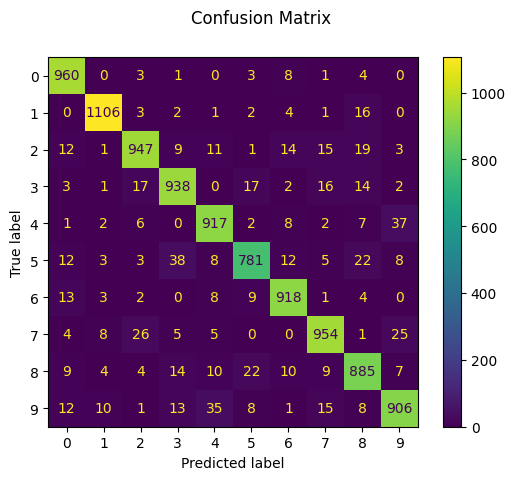

In [6]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error,explained_variance_score

A, cache= model.forward(X_test)
predicted = np.argmax(A, axis=0)
true_label = np.argmax(y_test_one_hot, axis=1)

print("Mean Squared Error: %.2f" % mean_squared_error(predicted, true_label))
print('Variance Score: %.2f' % explained_variance_score(true_label, predicted))

model.loss_plot()

print(
    f"Classification report for our MLP:\n"
    f"{metrics.classification_report(true_label, predicted)}\n"
)

disp = metrics.ConfusionMatrixDisplay.from_predictions(true_label, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# 调用sklearn中MLP分类方法

## 安装依赖

In [ ]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import warnings

## 调用MLP方法并设置参数

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(50,10),
    max_iter=30,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=2,
    learning_rate_init=0.1,
)

## 加载数据集开始训练

In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten images and normalize
X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

# Convert labels to one-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(X_train, y_train_one_hot)
print("Test score: %f" % mlp.score(X_test, y_test_one_hot))


## 预测并分析结果

Iteration 1, loss = 0.74300608
Iteration 2, loss = 0.31928305
Iteration 3, loss = 0.25737977
Iteration 4, loss = 0.22864899
Iteration 5, loss = 0.20665940
Iteration 6, loss = 0.19041468
Iteration 7, loss = 0.17804718
Iteration 8, loss = 0.16743818
Iteration 9, loss = 0.15638635
Iteration 10, loss = 0.15123697
Iteration 11, loss = 0.14208819
Iteration 12, loss = 0.13523487
Iteration 13, loss = 0.13131932
Iteration 14, loss = 0.12418164
Iteration 15, loss = 0.12506612
Iteration 16, loss = 0.11335291
Iteration 17, loss = 0.11642209
Iteration 18, loss = 0.11142872
Iteration 19, loss = 0.10660381
Iteration 20, loss = 0.09989390
Iteration 21, loss = 0.10030476
Iteration 22, loss = 0.09906076
Iteration 23, loss = 0.09535368
Iteration 24, loss = 0.09096313
Iteration 25, loss = 0.08709152
Iteration 26, loss = 0.08658443
Iteration 27, loss = 0.08618740
Iteration 28, loss = 0.08478028
Iteration 29, loss = 0.07978708
Iteration 30, loss = 0.07577203
Test score: 0.954000
Mean Squared Error: 0.91
Var

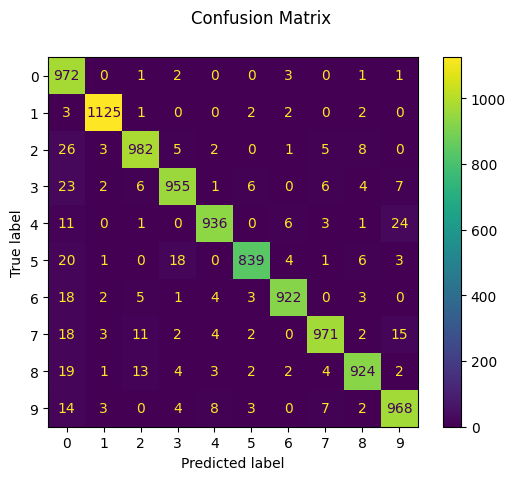

In [7]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error,explained_variance_score

predicted= mlp.predict(X_test)
predicted= np.argmax(predicted, axis=1)
true_label = np.argmax(y_test_one_hot, axis=1)

print("Mean Squared Error: %.2f" % mean_squared_error(predicted, true_label))
print('Variance Score: %.2f' % explained_variance_score(true_label, predicted))

print(
    f"Classification report for PyTorch MLP:\n"
    f"{metrics.classification_report(true_label, predicted)}\n"
)
disp = metrics.ConfusionMatrixDisplay.from_predictions(true_label, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()